# 3x3 assembly inputfile that: 

### Import module/Set up XS path/Create openMC model/Clean directory

In [24]:
import sys
import os 
import openmc
import numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs
import pandas as pd
from IPython.display import Image
import glob

%env OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml
model=openmc.Model()

clean_file_list = ["model.xml", "materials.xml", "geometry.xml","plots.xml","geometry.xml","settings.xml","tallies.out","summary.h5","statepoint.50.h5"]

for file in clean_file_list :
    path_file = os.path.join(os.getcwd(), file)
    if os.path.exists(path_file):
        os.remove(path_file)

env: OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml


### Define Materials

In [25]:
uo2 = openmc.Material(name='uo2')
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)
zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)
helium=openmc.Material(name='helium')
helium.add_element('helium',1)
helium.set_density('g/cm3',8e-4)
water = openmc.Material(name="water")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

    
model.materials = openmc.Materials([uo2, zirconium, water,helium]) 
model.materials.export_to_xml()

### Create pincell_in

In [26]:
fuel_outer_radius = openmc.ZCylinder(r=0.39)
gap_outer_radius = openmc.ZCylinder(r=0.40)
clad_outer_radius = openmc.ZCylinder(r=0.46)
pitch = 1.26
left = openmc.XPlane(-pitch/2, boundary_type='reflective')
right = openmc.XPlane(pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(-pitch/2, boundary_type='reflective')
top = openmc.YPlane(pitch/2, boundary_type='reflective')
    
fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -gap_outer_radius
clad_region = +gap_outer_radius & -clad_outer_radius
water_region = +left & -right & +bottom & -top & +clad_outer_radius
    
fuel_in = openmc.Cell(name='fuel_in')
fuel_in.fill = uo2
fuel_in.region = fuel_region
gap_in = openmc.Cell(name='gap_in')
gap_in.fill=helium
gap_in.region = gap_region
clad_in = openmc.Cell(name='clad_in')
clad_in.fill = zirconium
clad_in.region = clad_region
moderator_in = openmc.Cell(name='moderator_in')
moderator_in.fill = water
moderator_in.region = water_region

u_in = openmc.Universe(cells=(fuel_in, gap_in, clad_in, moderator_in))

### Plot Pincell

### Create pincell_out

In [27]:
fuel_out = openmc.Cell(name='fuel_out')
fuel_out.fill = uo2
fuel_out.region = fuel_region
gap_out = openmc.Cell(name='gap_out')
gap_out.fill=helium
gap_out.region = gap_region
clad_out = openmc.Cell(name='clad_out')
clad_out.fill = zirconium
clad_out.region = clad_region
moderator_out = openmc.Cell(name='moderator_out')
moderator_out.fill = water
moderator_out.region = water_region
    
u_out = openmc.Universe(cells=(fuel_out, gap_out, clad_out, moderator_out))

### Define assembly

In [28]:
   assembly = openmc.RectLattice()
assembly.lower_left = (-1.5*pitch, -1.5*pitch)
assembly.pitch = (1.26, 1.26)
assembly.universes = [[u_out, u_out, u_out],
                      [u_out, u_in, u_out],
                      [u_out, u_out, u_out]]
            
    
    
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

min_x = openmc.XPlane(x0=0., boundary_type='reflective')
max_x = openmc.XPlane(x0=+1.5*pitch, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0., boundary_type='reflective')
max_y = openmc.YPlane(y0=+1.5*pitch, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z
    
    
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)
model.geometry = openmc.Geometry(root_universe)
model.geometry.export_to_xml()


/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=0.
  warn(msg, IDWarning)


### Plot assembly

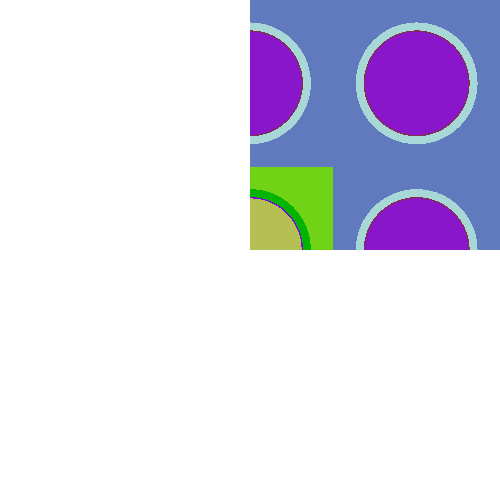

In [29]:
plot = openmc.Plot.from_geometry(model.geometry)
plot.pixels = (500, 500)
plot.width = (3*pitch, 3*pitch)
plot.origin = (0., 0., 0)
plot.color_by = 'cell'
# plot.colors = {
#     water: 'blue',
#     zirconium: 'black',
#     helium: 'yellow',
#     uo2_in: (100, 0, 0),
#     uo2_out: (255, 0, 0)
# }
plot.to_ipython_image()

### Choose settings

In [30]:
source = openmc.IndependentSource()
source.space = openmc.stats.Point((0.1,0.1,0.))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([10.0e6], [1.0])
source.time = openmc.stats.Uniform(0, 1e-6)
settings = openmc.Settings()
settings.source = source
settings = openmc.Settings()
settings.source = source
settings.batches = 50
settings.inactive = 10
settings.particles = 1000
settings.output = {'tallies':True}
model.settings = settings
model.settings.export_to_xml()

### Define and choose energy group

In [31]:
choose_group=openmc.mgxs.GROUP_STRUCTURES['XMAS-172']
name_group='XMAS172'

### Create flux tally

tally_flux=openmc.Tally(name='tally_flux')
flux_energy_filter = openmc.EnergyFilter(choose_group)
#cell_filter = openmc.CellFilter([fuel.id])
tally_flux.filters = [flux_energy_filter]#,cemll_filter]
tally_flux.scores = ['flux']
model.tallies.append(tally_flux)

### Create MGXS tallies for mgxs directory

In [32]:
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(choose_group)
mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.legendre_order = 3
mgxs_lib.mgxs_types = ['total', 'absorption', 'fission', 'nu-fission', 'chi', 'scatter matrix', 'nu-scatter matrix', 'inverse-velocity']
mgxs_lib.tally_trigger =openmc.Trigger('std_dev', 1e-2)
mgxs_lib.by_nuclide = False
mgxs_lib.domain_type = 'cell'
mgxs_lib.domains = model.geometry.get_all_material_cells().values()
mgxs_lib.build_library()
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies, merge=True)
#tally_flux.merge_tallies()
model.tallies = tallies
#print(model.tallies)

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 3 is greater than zero
  warn(msg, RuntimeWarning)


### Run OpenMC model

In [33]:
model.export_to_xml()
sp_file = model.run()
sp = openmc.StatePoint(sp_file)

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1120.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=842.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=850.
  warn(msg, IDWarning)


[Machine2:103855] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%

### Plot Flux

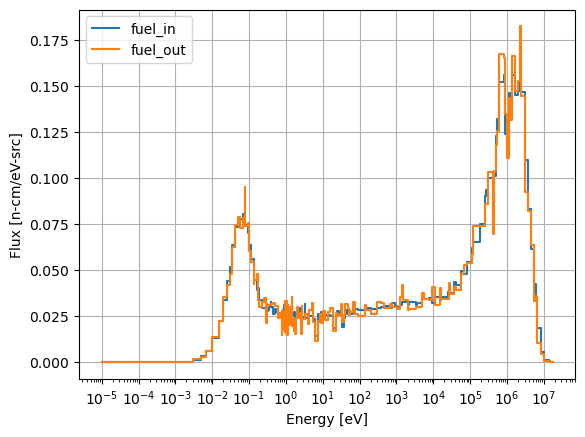

In [34]:
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import LogLocator

cell_plot=['fuel_in','fuel_out']#,'moderator_in','clad_in']#,'fuel_out','moderator_out','clad_out']


sp = openmc.StatePoint(sp_file)
sp.tallies
tally_flux_id=[]
for index, tally in enumerate(sp.tallies):
    if sp.tallies[tally].scores==['flux']:
        t=sp.tallies[tally]

def flux_cell(cell):
    
    cell_index = 99
    cell_id=99
    # print(model.geometry.get_all_material_cells().values())
    i=0
    for all_cell in model.geometry.get_all_material_cells().values():
        i=i+1
        if all_cell.name==cell:
            cell_index=all_cell.id
            cell_id=i-1
            # print(cell_id)
            
    tally_data_reshaped =t.get_reshaped_data()
    flux=tally_data_reshaped[cell_id]
    
    liste_reduced = []
    for under_liste in flux:
        nombre = under_liste[0][0]
        liste_reduced.append(nombre)
    flux=liste_reduced
    return(flux)
    

dE=np.diff(choose_group)
Emid=choose_group[:-1]+dE/2

fig, ax = plt.subplots()
for i,cell in enumerate(cell_plot):
    flux=flux_cell(cell_plot[i])    
    mg_spectrum=flux / np.sum(flux)
    ax.step(choose_group[:-1], Emid*mg_spectrum/dE, where='post', label=cell_plot[i])
ax.set_xscale('log')
ax.xaxis.set_major_locator(FixedLocator(locs=np.logspace(-5, 7, 13)))
locmin=LogLocator(base=10,subs=np.linspace(0,1.0,11)[1:-1],numticks=1000)
ax.xaxis.set_minor_locator(locmin)
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n-cm/eV-src]')
ax.grid()
ax.legend()
plt.show()


In [35]:
mgxs_lib.load_from_statepoint(sp)
type(mgxs_lib)
reaction_print = 'total'
cell_print=fuel_in
df_mgxs = mgxs_lib.get_mgxs(cell_print, reaction_print)
df_mgxs.print_xs()

Multi-Group XS
	Reaction Type  =	total
	Domain Type    =	cell
	Domain ID      =	19
	Cross Sections [cm^-1]:
            Group 1 [17332500.0 - 19640300.0eV]:	0.00e+00 +/- 0.00e+00%
            Group 2 [14918200.0 - 17332500.0eV]:	0.00e+00 +/- 0.00e+00%
            Group 3 [13840300.0 - 14918200.0eV]:	2.04e-01 +/- 1.03e+02%
            Group 4 [11618300.0 - 13840300.0eV]:	2.02e-01 +/- 5.94e+01%
            Group 5 [10000000.0 - 11618300.0eV]:	1.96e-01 +/- 4.58e+01%
            Group 6 [8187310.0  - 10000000.0eV]:	1.91e-01 +/- 2.49e+01%
            Group 7 [6703200.0  - 8187310.0 eV]:	1.97e-01 +/- 1.16e+01%
            Group 8 [6065310.0  - 6703200.0 eV]:	1.96e-01 +/- 1.10e+01%
            Group 9 [5488120.0  - 6065310.0 eV]:	2.24e-01 +/- 1.07e+01%
            Group 10 [4493290.0  - 5488120.0 eV]:	2.31e-01 +/- 6.45e+00%
            Group 11 [3678790.0  - 4493290.0 eV]:	2.72e-01 +/- 6.13e+00%
            Group 12 [3011940.0  - 3678790.0 eV]:	2.91e-01 +/- 5.07e+00%
            Group 13 [246

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/tallies.py:1278: RuntimeWarning: invalid value encountered in divide
  data = self.std_dev[indices] / self.mean[indices]


### Plot MGXS from mgxs directory

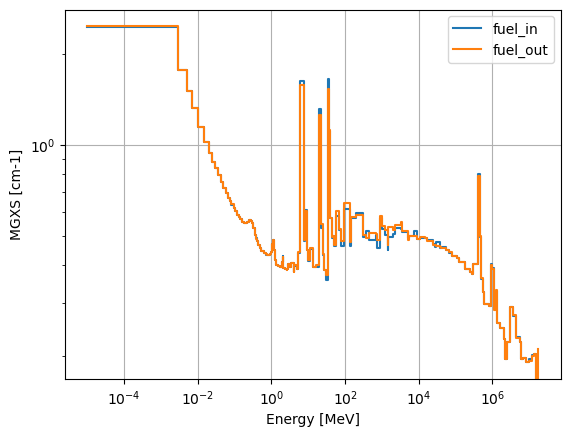

In [36]:
reaction_plot = 'total'
cell_plot_1 = fuel_in
cell_name_1='fuel_in'
cell_plot_2 = fuel_out
cell_name_2='fuel_out'


mgxs_plot_1 = mgxs_lib.get_mgxs(cell_plot_1, reaction_plot)

mgxs1=mgxs_plot_1.get_pandas_dataframe(xs_type='macro')['mean'].values
mgxs_plot_2 = mgxs_lib.get_mgxs(cell_plot_2, reaction_plot)
mgxs2=mgxs_plot_2.get_pandas_dataframe(xs_type='macro')['mean'].values


fig, ax = plt.subplots()
ax.step(choose_group[:-1], np.flip(mgxs1), where='post', label=cell_name_1) 
ax.step(choose_group[:-1], np.flip(mgxs2), where='post', label=cell_name_2) 

        
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('MGXS [cm-1]')
ax.grid() 
# bbox = ax.get_position()
# ax.text(bbox.x1 - 0.05, bbox.y0 - 0.05, reaction_plot, fontsize=15, color='red', ha='right')
ax.legend()
plt.show()